# US Regional Housing Price Trend Prediction
To extend our scope to the national level broken down by regions, we examine this Refin weekly housing market dataset (https://www.redfin.com/news/data-center/). It covers detailed market trends from 2017 to 2021 totaling 1.76 million weekly instances. As massive as it is, our modeling will only focus on sale volume and price, and make predictions of whether the price increases for a given year.

## Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 59.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=ba5e6c555ab207ddf2c10fcc7c7f248b25a004be038d26cb75cfcca5d6a9ff93
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("us_weekly").getOrCreate()

In [ ]:
file_path = '/content/drive/MyDrive/weekly_housing_market_data_most_recent.tsv'

In [ ]:
sdf = spark.read.csv(file_path, sep=r'\t', header=True)
sdf.createOrReplaceTempView("raw_data")
sdf.show()

+---------+--------------+--------------------+-----------+------------+----------+--------+----------------+--------------------+------------------+----------------------+---------------------------------+-------------------------------------+-----------------------------------+---------------------------------------+-----------------------------------+---------------------------------------+-----------------+---------------------+------------------+--------------------+--------------------+------------------------+-----------+--------------------+----------------------------------------+--------------------------------------------+-------------+--------------------+-------------------+-----------------------+-----------------------+---------------------------+----------------------+--------------------------+-------------------------------+-----------------------------------+------------------------------+----------------------------------+------------------+----------------------+--

In [ ]:
print(f"({sdf.count()}, {len(sdf.columns)})")

(1761969, 98)


## Pre-processing

### Projection
We only keep the columns relevant to the modeling. We use `period_begin` as the date.

In [ ]:
data_query = """
  select region_name, period_begin, total_homes_sold, median_sale_price
  from raw_data
"""
data_sdf = spark.sql(data_query)
data_sdf.createOrReplaceTempView("data")
data_sdf.show()

+--------------------+------------+----------------+-----------------+
|         region_name|period_begin|total_homes_sold|median_sale_price|
+--------------------+------------+----------------+-----------------+
|Isle of Wight Cou...|  2019-04-22|            15.0|         294000.0|
|Jackson, OH metro...|  2020-07-20|            null|             null|
|  Jackson County, MN|  2021-05-10|             1.0|         134900.0|
|New Ulm, MN metro...|  2020-08-03|            null|             null|
|   Morgan County, GA|  2020-08-17|             3.0|         377500.0|
|  Steuben County, NY|  2019-08-12|            14.0|          92450.0|
|  Jackson County, MN|  2018-10-15|             2.0|          96000.0|
| Columbia County, WA|  2021-05-10|            null|             null|
|    Marin County, CA|  2020-08-03|            95.0|        1199000.0|
|    Delta County, TX|  2017-10-09|             1.0|         104000.0|
| Columbia County, WA|  2020-06-29|             2.0|         453500.0|
|   Me

### Converting Data Types

In [ ]:
data_sdf.dtypes

[('region_name', 'string'),
 ('period_begin', 'string'),
 ('total_homes_sold', 'string'),
 ('median_sale_price', 'string')]

In [ ]:
data_type_query = """
  select region_name,
  to_date(period_begin, "yyyy-MM-dd") as period_begin,
  cast(total_homes_sold as int) as total_homes_sold,
  cast(median_sale_price as int) as median_sale_price
  from data
"""
data_type_sdf = spark.sql(data_type_query)
data_type_sdf.show()

+--------------------+------------+----------------+-----------------+
|         region_name|period_begin|total_homes_sold|median_sale_price|
+--------------------+------------+----------------+-----------------+
|Isle of Wight Cou...|  2019-04-22|              15|           294000|
|Jackson, OH metro...|  2020-07-20|            null|             null|
|  Jackson County, MN|  2021-05-10|               1|           134900|
|New Ulm, MN metro...|  2020-08-03|            null|             null|
|   Morgan County, GA|  2020-08-17|               3|           377500|
|  Steuben County, NY|  2019-08-12|              14|            92450|
|  Jackson County, MN|  2018-10-15|               2|            96000|
| Columbia County, WA|  2021-05-10|            null|             null|
|    Marin County, CA|  2020-08-03|              95|          1199000|
|    Delta County, TX|  2017-10-09|               1|           104000|
| Columbia County, WA|  2020-06-29|               2|           453500|
|   Me

In [ ]:
data_type_sdf.schema

StructType(List(StructField(region_name,StringType,true),StructField(period_begin,DateType,true),StructField(total_homes_sold,IntegerType,true),StructField(median_sale_price,IntegerType,true)))

### Duplicates and Missing Values

In [ ]:
data_type_sdf = data_type_sdf.dropDuplicates()

In [ ]:
data_type_sdf = data_type_sdf.na.drop()

In [ ]:
data_type_sdf.count()

1515556

In [ ]:
data_type_sdf.createOrReplaceTempView("data_type")

### Aggregation
We extract year and month and aggregate by region and year.

In [ ]:
yr_mo_query = """
  select *, year(period_begin) as year, month(period_begin) as month
  from data_type
"""
yr_mo_sdf = spark.sql(yr_mo_query)
yr_mo_sdf.createOrReplaceTempView("yr_mo")
yr_mo_sdf.show()

+--------------------+------------+----------------+-----------------+----+-----+
|         region_name|period_begin|total_homes_sold|median_sale_price|year|month|
+--------------------+------------+----------------+-----------------+----+-----+
|Tulsa, OK metro area|  2019-09-09|             325|           180000|2019|    9|
|Wyandotte County, KS|  2020-06-29|              50|           156250|2020|    6|
|   Cassia County, ID|  2020-05-25|               5|           179000|2020|    5|
|     Drew County, AR|  2021-05-31|               3|           195000|2021|    5|
|Montgomery County...|  2020-11-02|               1|            37500|2020|   11|
|  Portage County, WI|  2019-06-24|              26|           196750|2019|    6|
|   Warren County, OH|  2019-04-15|              76|           275000|2019|    4|
|Montgomery County...|  2020-09-14|               2|           143750|2020|    9|
| Harrison County, IN|  2019-10-21|               8|           180000|2019|   10|
|  Clinton Count

In [ ]:
agg_query = """
  select region_name, year, month, sum(total_homes_sold) as homes_sold, avg(median_sale_price) as sale_price
  from yr_mo
  group by region_name, year, month
"""
agg_sdf = spark.sql(agg_query)
agg_sdf.createOrReplaceTempView("agg")
agg_sdf.show()

+--------------------+----+-----+----------+------------------+
|         region_name|year|month|homes_sold|        sale_price|
+--------------------+----+-----+----------+------------------+
| Herkimer County, NY|2020|    2|       553| 84408.83333333333|
|    Meigs County, TN|2019|    6|        60|          170095.2|
| Richmond County, GA|2017|    7|      3617|          125873.0|
|Pend Oreille Coun...|2018|    4|       273| 232102.2142857143|
| Anderson County, KY|2017|    3|       391|          139423.0|
| Napa, CA metro area|2018|    5|      1880| 700052.4166666666|
|Washington County...|2019|    9|       305|156754.53333333333|
|Georgetown County...|2021|    2|      2908|          336544.5|
|    Marin County, CA|2019|   10|      3562|1166447.6666666667|
| Valencia County, NM|2018|    5|      1118|         164088.75|
|El Dorado County, CA|2020|    5|      5782|         523690.75|
|St. Francois Coun...|2018|    2|       906|118558.16666666667|
|    Bryan County, GA|2021|    7|      1

### Reshaping
This creates two features for each month.

In [ ]:
reshape_query = """
  select region_name, year,
    sum(case month when 1 then  homes_sold else 0 end) as jan_homes_sold,
    sum(case month when 2 then  homes_sold else 0 end) as feb_homes_sold,
    sum(case month when 3 then  homes_sold else 0 end) as mar_homes_sold,
    sum(case month when 4 then  homes_sold else 0 end) as apr_homes_sold,
    sum(case month when 5 then  homes_sold else 0 end) as may_homes_sold,
    sum(case month when 6 then  homes_sold else 0 end) as jun_homes_sold,
    sum(case month when 7 then  homes_sold else 0 end) as jul_homes_sold,
    sum(case month when 8 then  homes_sold else 0 end) as aug_homes_sold,
    sum(case month when 9 then  homes_sold else 0 end) as sep_homes_sold,
    sum(case month when 10 then homes_sold else 0 end) as oct_homes_sold,
    sum(case month when 11 then homes_sold else 0 end) as nov_homes_sold,
    sum(case month when 12 then homes_sold else 0 end) as dec_homes_sold,
    sum(case month when 1 then  sale_price else 0 end) as jan_sale_price,
    sum(case month when 2 then  sale_price else 0 end) as feb_sale_price,
    sum(case month when 3 then  sale_price else 0 end) as mar_sale_price,
    sum(case month when 4 then  sale_price else 0 end) as apr_sale_price,
    sum(case month when 5 then  sale_price else 0 end) as may_sale_price,
    sum(case month when 6 then  sale_price else 0 end) as jun_sale_price,
    sum(case month when 7 then  sale_price else 0 end) as jul_sale_price,
    sum(case month when 8 then  sale_price else 0 end) as aug_sale_price,
    sum(case month when 9 then  sale_price else 0 end) as sep_sale_price,
    sum(case month when 10 then sale_price else 0 end) as oct_sale_price,
    sum(case month when 11 then sale_price else 0 end) as nov_sale_price,
    sum(case month when 12 then sale_price else 0 end) as dec_sale_price
  from agg
  group by region_name, year
"""
reshape_sdf = spark.sql(reshape_query)
reshape_sdf.createOrReplaceTempView("reshape")
reshape_sdf.show()

+--------------------+----+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|         region_name|year|jan_homes_sold|feb_homes_sold|mar_homes_sold|apr_homes_sold|may_homes_sold|jun_homes_sold|jul_homes_sold|aug_homes_sold|sep_homes_sold|oct_homes_sold|nov_homes_sold|dec_homes_sold|    jan_sale_price|    feb_sale_price|    mar_sale_price|    apr_sale_price|    may_sale_price|    jun_sale_price|    jul_sale_price|    aug_sale_price|    sep_sale_price|    oct_sale_price|    nov_sale_price|    dec_sale_price|
+--------------------+----+--------------+--------------+--------------+--------------+--------------+--------------+-----------

### Labeling
The price trend in a given year is used as the label. For modeling purpose 1 represents increasing price and 0 otherwise.

In [ ]:
trend_query = """
  select *, if(dec_sale_price > jan_sale_price, 1, 0) as label
  from reshape
"""
trend_sdf = spark.sql(trend_query)
trend_sdf.createOrReplaceTempView("trend")
trend_sdf.show()

+--------------------+----+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----+
|         region_name|year|jan_homes_sold|feb_homes_sold|mar_homes_sold|apr_homes_sold|may_homes_sold|jun_homes_sold|jul_homes_sold|aug_homes_sold|sep_homes_sold|oct_homes_sold|nov_homes_sold|dec_homes_sold|    jan_sale_price|    feb_sale_price|    mar_sale_price|    apr_sale_price|    may_sale_price|    jun_sale_price|    jul_sale_price|    aug_sale_price|    sep_sale_price|    oct_sale_price|    nov_sale_price|    dec_sale_price|label|
+--------------------+----+--------------+--------------+--------------+--------------+--------------+--------------

### Features Vector Assembly

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
all_columns = trend_sdf.columns
drop_columns = ["region_name", "year", "label"]
columns_to_use = [i for i in all_columns if i not in drop_columns]
assembler = VectorAssembler(inputCols=columns_to_use, outputCol="features")

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[assembler])
model = pipeline.fit(trend_sdf)
modified_data_sdf = model.transform(trend_sdf)
modified_data_sdf.show()

+--------------------+----+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----+--------------------+
|         region_name|year|jan_homes_sold|feb_homes_sold|mar_homes_sold|apr_homes_sold|may_homes_sold|jun_homes_sold|jul_homes_sold|aug_homes_sold|sep_homes_sold|oct_homes_sold|nov_homes_sold|dec_homes_sold|    jan_sale_price|    feb_sale_price|    mar_sale_price|    apr_sale_price|    may_sale_price|    jun_sale_price|    jul_sale_price|    aug_sale_price|    sep_sale_price|    oct_sale_price|    nov_sale_price|    dec_sale_price|label|            features|
+--------------------+----+--------------+--------------+--------------+--

## Modeling

In [ ]:
train_sdf, test_sdf = modified_data_sdf.randomSplit([.8, .2])

### Random Forest Classification

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(train_sdf)
trainingSummary = rf_model.summary

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


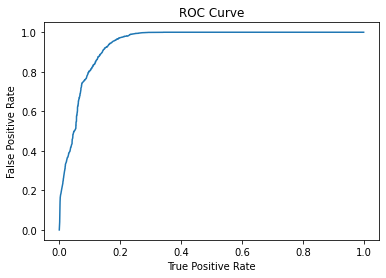

Train Area Under ROC: 0.9412000607628451


In [ ]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Train Area Under ROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions = rf_model.transform(test_sdf)
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9435759325480506


### Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=10)
lr_model = lr.fit(train_sdf)
trainingSummary = lr_model.summary

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


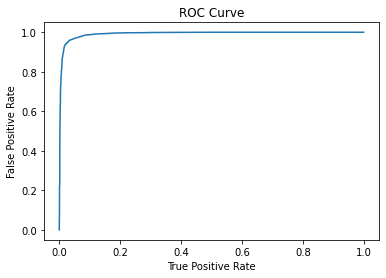

Train Area Under ROC: 0.9921621172949794


In [ ]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Train Area Under ROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
predictions = lr_model.transform(test_sdf)
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.990124984835443


### Logistic Regression with Regularization
Since the AUC is high, we also experiment with regularization. Only Ridge is able to distinguish the classes. We think it's because our modified dataset does have many important features and multicollinearity.

In [ ]:
# Elastic-Net
en_lr = LogisticRegression(maxIter=10, regParam=.3, elasticNetParam=.8)
en_lr_model = en_lr.fit(train_sdf)
trainingSummary = en_lr_model.summary
print('Train Area Under ROC: ' + str(trainingSummary.areaUnderROC))

Train Area Under ROC: 0.5


In [ ]:
# Lasso
l1_lr = LogisticRegression(maxIter=10, regParam=.3, elasticNetParam=1)
l1_lr_model = l1_lr.fit(train_sdf)
trainingSummary = l1_lr_model.summary
print('Train Area Under ROC: ' + str(trainingSummary.areaUnderROC))

Train Area Under ROC: 0.5


In [ ]:
# Ridge
l2_lr = LogisticRegression(maxIter=10, regParam=.3, elasticNetParam=0)
l2_lr_model = l2_lr.fit(train_sdf)
trainingSummary = l2_lr_model.summary
print('Train Area Under ROC: ' + str(trainingSummary.areaUnderROC))

Train Area Under ROC: 0.9090755030776216


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


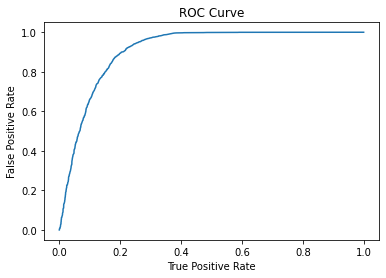

In [ ]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
predictions = l2_lr_model.transform(test_sdf)
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.906946305913893


### Conclusion

In this part, we reshaped the US Housing Price dataset in a different way. By aggregating the house price and sold number for each county in different month, we were able to train a random forest model and a logistic regression with ridge model with pretty decent scores.